# Probando con nuevas imagenes

Cargamos los clasificadores:

In [1]:
import pickle

path = '..//rsc//obj//'

# Todas las rutas
svm_path = path + 'svm_clf.sav'
svm2_path = path + 'svm2_clf.sav'
gtb_path = path + 'gtb_clf.sav'
rf_path = path + 'rf_clf.sav'

# Serizalización
svm_clf = pickle.load(open(svm_path, 'rb'))
svm2_clf = pickle.load(open(svm2_path, 'rb'))
gtb_clf = pickle.load(open(gtb_path, 'rb'))
rf_clf = pickle.load(open(rf_path, 'rb'))

classifiers = [svm_clf, 
               svm2_clf, 
               gtb_clf, 
               rf_clf
]

# Funciones auxiliares

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [3]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [4]:
# import the necessary packages
import numpy as np

# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

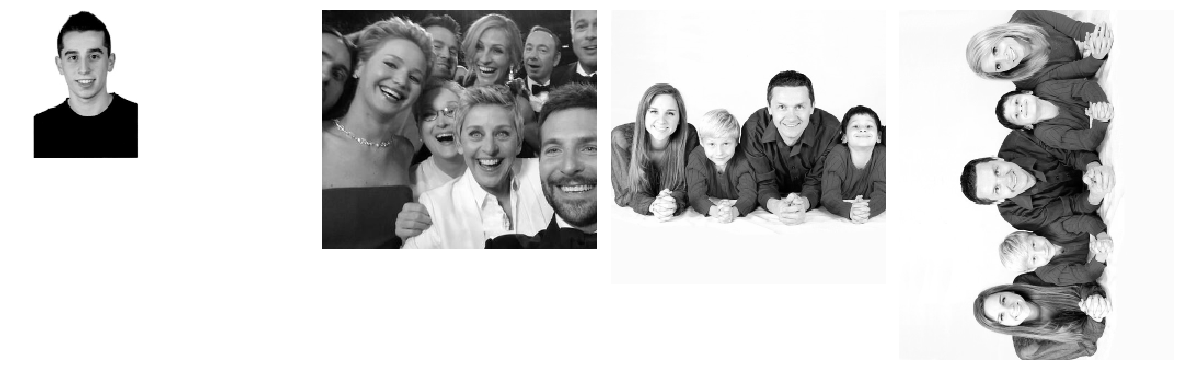

In [5]:
#Imports
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity
from skimage import io, feature
from skimage.transform import rescale
from skimage.color import rgb2gray
import cv2

img1 = io.imread("..\\rsc\\img\\my_face.jpg")
img2 = io.imread("..\\rsc\\img\\faces_test.jpg")
img3 = io.imread("..\\rsc\\img\\family.jpg")
img4 = io.imread("..\\rsc\\img\\rotated_family.jpg")

imgs = [img1, img2, img3, img4]
rescale_list = [0.3, 0.65, 0.5, 0.5]

# Convertimos imagen a escala de grises
for index in range(len(imgs)):
    imgs[index] = rgb2gray(imgs[index])
    imgs[index] = rescale(imgs[index], rescale_list[index])

# Rotamos la ultima imagen 90 grados
img4 = rgb2gray(img4)
img4 = rescale(img4, 0.5)

# Mostramos la imagen resultante
fig, axes = plt.subplots(ncols=len(imgs), figsize=(16, 5.4), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})

for index in range(len(imgs)):
    axes[index].imshow(imgs[index], cmap='gray')
    axes[index].axis('off');

fig.subplots_adjust(hspace=0.01, wspace=0.01, top=0.9, bottom=0, left=0,
                    right=1)
plt.show()

In [27]:
all_indices = []
all_patches = []
all_patches_hog = []

for index in range(len(imgs)):
    indices, patches = zip(*sliding_window(imgs[index]))
    all_indices.append(np.array(indices))
    all_patches.append(patches)
    all_patches_hog.append(np.array([feature.hog(patch) for patch in patches]))
#print(all_indices)
    #print(all_patches_hog[-1].shape)

In [28]:
labels = []
for i in range(len(classifiers)):
    for j in range(len(imgs)):
        if i != 0 and i != 1:
            labels.append(classifiers[i].predict_proba(all_patches_hog[j])[:,1])
        else:
            labels.append(classifiers[i].predict(all_patches_hog[j]))

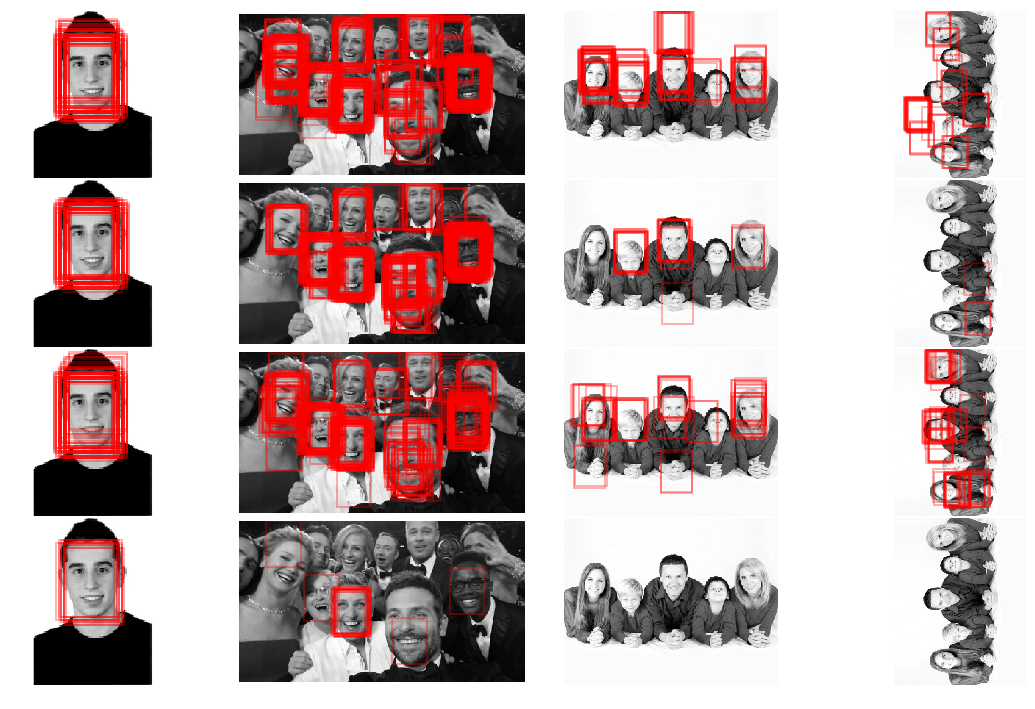

In [29]:
# Mostramos las imagenes resultante
fig, axes = plt.subplots(nrows=len(classifiers), ncols=len(imgs), 
                         figsize=(16, 10.4),# sharex=True, sharey=True, 
                         subplot_kw={'adjustable':'box-forced'})
axes = axes.ravel()

k = 0
all_boxes = list()
for clf_index in range(len(classifiers)):
    for img_index in range(len(imgs)):
        
        axes[k].imshow(imgs[img_index], cmap='gray')
        axes[k].axis('off')

        Ni, Nj = positive_patches[0].shape
        
        indices = all_indices[img_index]#np.array(all_indices[k])

        boxes = list()
        for i, j in indices[labels[k] > 0.95]:
            boxes.append((j,i,j+Nj,i+Ni))
            axes[k].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                                       alpha=0.3, lw=2, facecolor='none'))
        all_boxes.append(np.array(boxes))
        k += 1

fig.subplots_adjust(hspace=0.01, wspace=0.01, top=0.9, bottom=0, left=0,
                     right=1)
plt.show()

In [30]:
# k=0
# for clf_index in range(len(classifiers)):
#     for imgs_index in range(len(imgs)):
#         image = imgs[imgs_index]
#         orig = image.copy()
#         boundingBoxes = all_boxes[k]
#         # loop over the bounding boxes for each image and draw them
#         for (startX, startY, endX, endY) in boundingBoxes:
#             cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 0, 255), 2)

#         # perform non-maximum suppression on the bounding boxes
#         pick = non_max_suppression_fast(boundingBoxes, 0.3)
#         #print "[x] after applying non-maximum, %d bounding boxes" % (len(pick))

#         # loop over the picked bounding boxes and draw them
#         for (startX, startY, endX, endY) in pick:
#             cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

#         # display the images
#         cv2.imshow("Original", orig)
#         cv2.imshow("After NMS", image)
#         cv2.waitKey(0)
#         k += 1

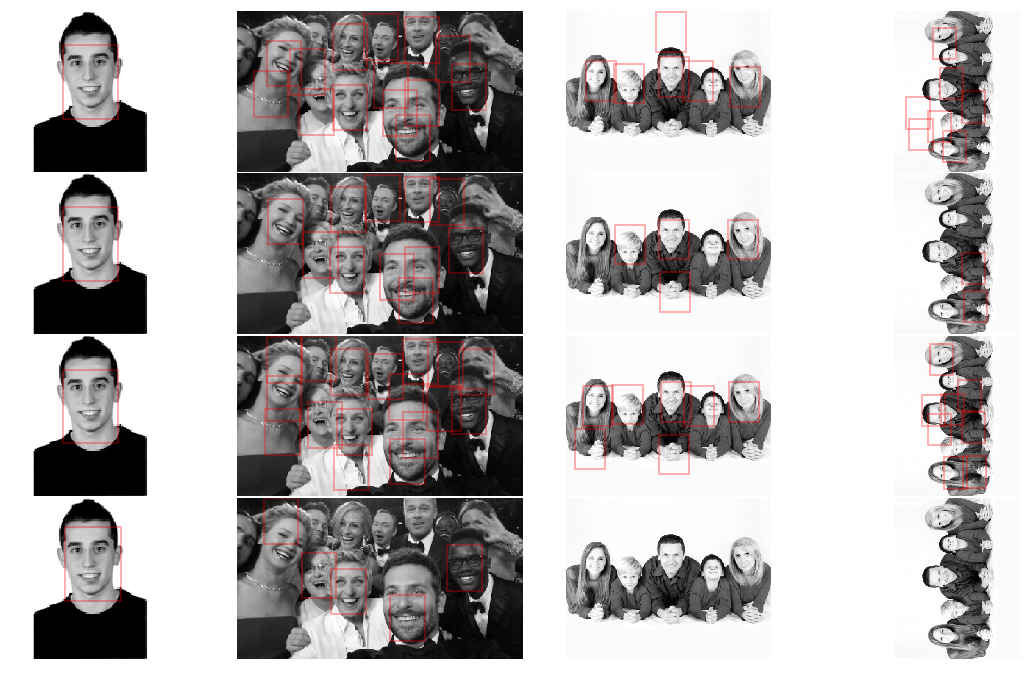

In [31]:
# Mostramos las imagenes resultantes
fig, axes = plt.subplots(nrows=len(classifiers), ncols=len(imgs), 
                         figsize=(16, 10), #sharex=True, sharey=True, 
                         subplot_kw={'adjustable':'box-forced'})
axes = axes.ravel()

k = 0
for clf_index in range(len(classifiers)):
    for imgs_index in range(len(imgs)):
        image = imgs[imgs_index]
        boundingBoxes = all_boxes[k]
        
        # perform non-maximum suppression on the bounding boxes
        pick = non_max_suppression_fast(boundingBoxes, 0.3)
        
        axes[k].imshow(image, cmap='gray')
        axes[k].axis('off')
        
        
        for (i, j, _, _) in pick:
            #print(i, j, Ni, Nj)
            axes[k].add_patch(plt.Rectangle((i, j), Nj, Ni, edgecolor='red',
                                            alpha=0.3, lw=2, facecolor='none'))
        k += 1
        
fig.subplots_adjust(hspace=0.01, wspace=0.01, top=0.9, bottom=0, left=0,
                     right=1)
plt.show()